In [1]:
CUDA_INDEX = 2
NAME = 'GED_LINUX'

In [2]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [3]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [4]:
outer_test_set = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/outer_test.pt', map_location='cpu')
queries, targets, lb, ub = outer_test_set

In [5]:
preds = [
    ('NeuroSED_G     ', torch.load(f'../preds/{NAME}/outer_pred.pt', map_location='cpu')),
    ('NeuroSED_G-Norm', torch.load(f'../preds/{NAME}/norm_outer_pred.pt', map_location='cpu')),
#     ('NeuroSED_G-NN  ', torch.load(f'../preds/{NAME}/nn_outer_pred.pt', map_location='cpu')),
#     ('NeuroSED_G-Dual', torch.load(f'../preds/{NAME}/dual_outer_pred.pt', map_location='cpu')),
    ('H2MN-RW        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw.npy')).view(len(queries), len(targets))),
    ('H2MN-NE        ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne.npy')).view(len(queries), len(targets))),
    ('SimGNN         ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_outer_pred.npy')).view(len(queries), len(targets))),
    ('Branch         ', torch.load(f'../preds/{NAME}/b_outer_pred.pt', map_location='cpu')),
    ('F2             ', torch.load(f'../preds/{NAME}/f2_outer_pred.pt', map_location='cpu')),
]

In [6]:
def range_metrics(fn, lb, ub, preds, ylabel, title, percent=True):
    r = torch.arange(1, int(torch.max(lb).item()), 1)
    plt.figure()
    Ys = []
    for label, pred in preds:
        Y = fn(r, lb, ub, pred)
        viz.plot_summary(r, Y, show_std=False, label=label, lim=percent)
        Ys.append((Y, label))
    plt.legend()
    plt.xlabel('range')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

    for Y, label in Ys:
#         print(f'{label}', end='\n')
        Z = utils.nanmean(Y, dim=-1)
        for i in [1,5,10,15,20]:
            if percent:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
            else:
                print(f'{Z[(i*Z.shape[0]//100+1)-1].item()*100:.2f}', end=' / ' if i != 20 else '\n')
#         print()

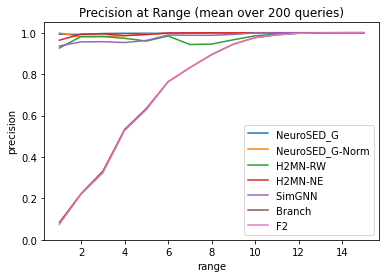

99.26 / 99.26 / 99.20 / 99.61 / 99.72
99.87 / 99.87 / 98.10 / 98.18 / 98.50
92.61 / 92.61 / 98.17 / 98.14 / 97.30
96.40 / 96.40 / 99.32 / 99.43 / 98.63
93.60 / 93.60 / 95.60 / 95.66 / 95.26
8.38 / 8.38 / 22.32 / 33.15 / 53.31
7.46 / 7.46 / 21.98 / 32.27 / 52.71


In [7]:
range_metrics(metrics.precision_at_range, lb, ub, preds,
              'precision', f'Precision at Range (mean over {len(queries)} queries)')

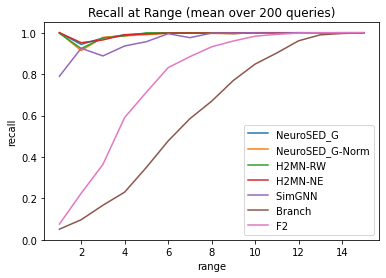

100.00 / 100.00 / 94.36 / 97.45 / 98.92
100.00 / 100.00 / 91.35 / 97.76 / 98.49
99.73 / 99.73 / 92.36 / 97.45 / 98.48
100.00 / 100.00 / 95.18 / 96.51 / 99.06
78.97 / 78.97 / 92.49 / 88.79 / 93.60
5.13 / 5.13 / 9.69 / 16.68 / 23.02
7.58 / 7.58 / 22.45 / 36.40 / 59.06


In [8]:
range_metrics(metrics.recall_at_range, lb, ub, preds,
              'recall', f'Recall at Range (mean over {len(queries)} queries)')

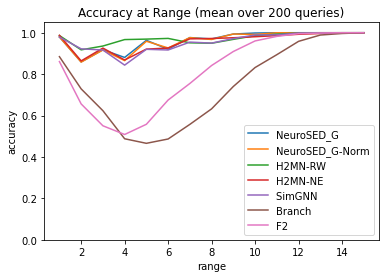

97.97 / 97.97 / 85.90 / 91.76 / 88.06
97.97 / 97.97 / 85.81 / 91.67 / 86.53
98.63 / 98.63 / 91.73 / 93.57 / 96.69
98.74 / 98.74 / 86.39 / 92.58 / 86.83
97.92 / 97.92 / 92.21 / 91.64 / 84.35
88.44 / 88.44 / 72.88 / 62.34 / 48.79
86.06 / 86.06 / 65.61 / 55.06 / 50.85


In [9]:
range_metrics(metrics.accuracy_at_range, lb, ub, preds,
              'accuracy', f'Accuracy at Range (mean over {len(queries)} queries)')

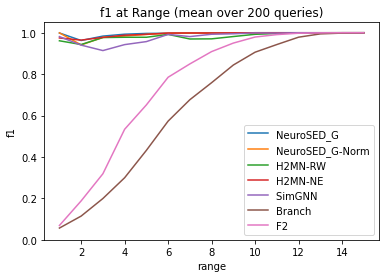

99.87 / 99.87 / 96.25 / 98.36 / 99.28
99.93 / 99.93 / 94.11 / 97.75 / 98.41
96.11 / 96.11 / 94.29 / 97.67 / 97.81
97.46 / 97.46 / 96.43 / 97.76 / 98.80
98.12 / 98.12 / 94.01 / 91.38 / 94.26
5.67 / 5.67 / 11.46 / 19.94 / 29.97
6.91 / 6.91 / 18.79 / 31.89 / 53.37


In [10]:
range_metrics(metrics.f1_at_range, lb, ub, preds,
              'f1', f'f1 at Range (mean over {len(queries)} queries)')

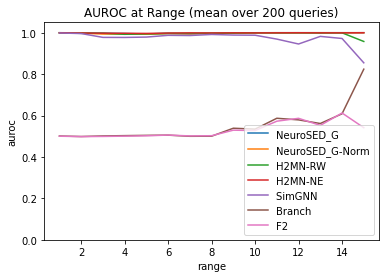

100.00 / 100.00 / 99.94 / 99.77 / 99.61
100.00 / 100.00 / 99.81 / 99.36 / 99.39
99.98 / 99.98 / 99.70 / 99.74 / 99.24
99.97 / 99.97 / 99.83 / 99.77 / 99.73
99.87 / 99.87 / 99.60 / 97.75 / 97.72
50.11 / 50.11 / 49.87 / 50.15 / 50.30
50.03 / 50.03 / 49.83 / 49.92 / 50.05


In [11]:
range_metrics(metrics.auroc_at_range, lb, ub, preds,
              'auroc', f'AUROC at Range (mean over {len(queries)} queries)')

# 